# Laplacian segmentation

This notebook implements the laplacian segmentation method of [McFee and Ellis, 2014](http://bmcfee.github.io/papers/ismir2014_spectral.pdf), with a couple of minor stability improvements.

In [1]:
from __future__ import print_function

In [2]:
import librosa
import librosa.display
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.cluster
import librosa.display
import sys
try:
    sys.getwindowsversion()
except AttributeError:
    isWindows = False
else:
    isWindows = True

if isWindows:
    import win32api,win32process,win32con
    pid = win32api.GetCurrentProcessId()
    handle = win32api.OpenProcess(win32con.PROCESS_ALL_ACCESS, True, pid)
    win32process.SetPriorityClass(handle, win32process.HIGH_PRIORITY_CLASS)

In [4]:
y, sr = librosa.load('audio/Karissa_Hobbs_-_09_-_Lets_Go_Fishin.mp3')

In [8]:
C = librosa.amplitude_to_db(np.abs(librosa.cqt(y=y, sr=sr, bins_per_octave=12*3, n_bins=7*12*3))**2,
                         ref=np.max)

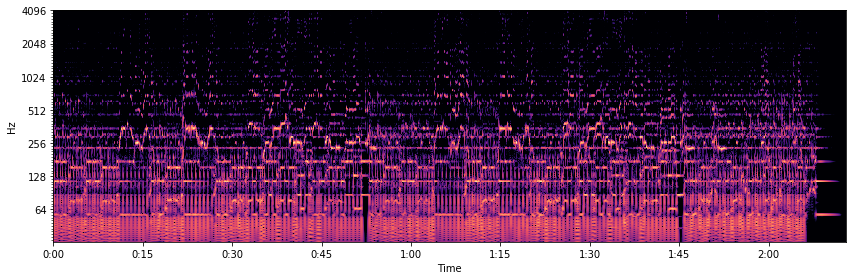

In [9]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr, bins_per_octave=12*3, x_axis='time')
plt.tight_layout()

In [10]:
# Let's beat-synchronize this to reduce dimensionality
tempo, beats = librosa.beat.beat_track(y=y, sr=sr, trim=False)
Csync = librosa.util.sync(C, beats, aggregate=np.median)

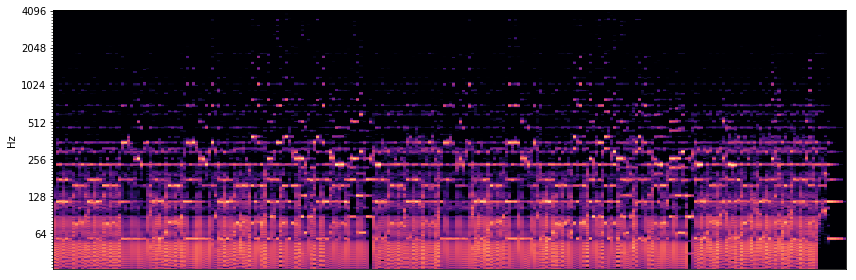

In [11]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(Csync, bins_per_octave=12*3, y_axis='cqt_hz')
plt.tight_layout()

In [12]:
# Let's build a weighted recurrence matrix from this
R = librosa.segment.recurrence_matrix(Csync, width=3, mode='affinity', sym=True)

In [13]:
# And enhance diagonals with a median filter
df = librosa.segment.timelag_filter(scipy.ndimage.median_filter)
Rf = df(R, size=(1, 5))

In [14]:
# Now let's build the sequence matrix using mfcc-similarity
# R_path[i, i+] = exp(-|C_i - C_j|^2 / bw)
mfcc = librosa.feature.mfcc(y=y, sr=sr)
Msync = librosa.util.sync(mfcc, beats)

path_distance = np.sum(np.diff(Msync, axis=1)**2, axis=0)
bw = np.mean(path_distance)
path_sim = np.exp(-path_distance / bw)

R_path = np.diag(path_sim, k=1) + np.diag(path_sim, k=-1)

In [15]:
# And compute the balanced combination

deg_path = np.sum(R_path, axis=1)
deg_rec = np.sum(Rf, axis=1)

mu = deg_path.dot(deg_path + deg_rec) / np.sum((deg_path + deg_rec)**2)

A = mu * Rf + (1 - mu) * R_path

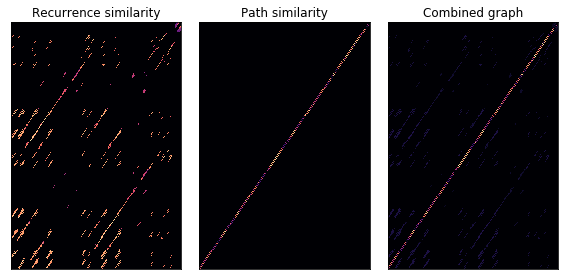

In [16]:
plt.figure(figsize=(8, 4))
plt.subplot(1,3,1)
librosa.display.specshow(Rf)
plt.title('Recurrence similarity')
plt.subplot(1,3,2)
librosa.display.specshow(R_path)
plt.title('Path similarity')
plt.subplot(1,3,3)
librosa.display.specshow(A)
plt.title('Combined graph')
plt.tight_layout()

In [17]:
# Now let's compute the symmetric normalized laplacian
L = scipy.sparse.csgraph.laplacian(A, normed=True)

In [18]:
# And its spectral decomposition
evals, evecs = scipy.linalg.eigh(L)

In [19]:
# We can clean this up further with a median filter.
# This can help smooth over brief discontinuities
evecs = scipy.ndimage.median_filter(evecs, size=(7, 1))

In [20]:
# cumulative normalization is needed for symmetric normalize laplacian eigenvectors
Cnorm = np.cumsum(evecs**2, axis=1)**0.5

# If we want k clusters, use the first k normalized eigenvectors.
# Fun exercise: see how segment changes as you vary k

k = 4

X = evecs[:, :k] / Cnorm[:, k-1:k]

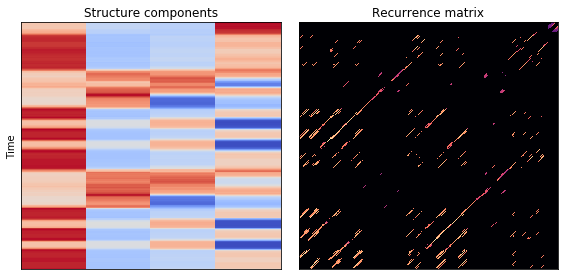

In [21]:
plt.figure(figsize=(8, 4))
plt.subplot(1,2,2)
librosa.display.specshow(Rf)
plt.title('Recurrence matrix')

plt.subplot(1,2,1)
librosa.display.specshow(X)
plt.title('Structure components')
plt.ylabel('Time')
plt.tight_layout()

In [22]:
# Let's use these k components to cluster
KM = sklearn.cluster.KMeans(n_clusters=k)

seg_ids = KM.fit_predict(X)

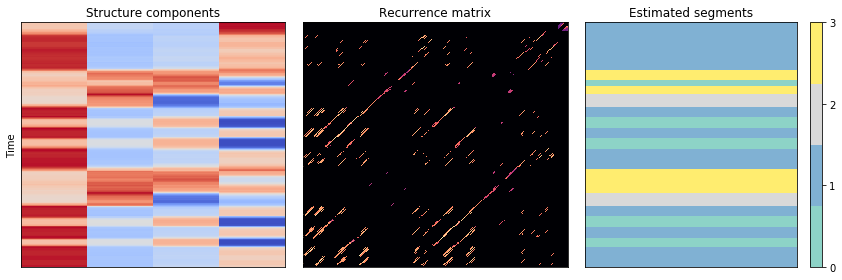

In [23]:
plt.figure(figsize=(12, 4))
plt.subplot(1,3,2)
librosa.display.specshow(Rf)
plt.title('Recurrence matrix')
plt.subplot(1,3,1)
librosa.display.specshow(X)
plt.title('Structure components')
plt.ylabel('Time')
plt.subplot(1,3,3)
librosa.display.specshow(np.atleast_2d(seg_ids).T, cmap=plt.get_cmap('Set3', k))
plt.title('Estimated segments')
plt.colorbar(ticks=range(k))
plt.tight_layout()

In [24]:
# Convert the segment ids back to indices of segment boundaries
bound_beats = np.flatnonzero(seg_ids[1:] != seg_ids[:-1])

In [25]:
# Convert beat indices to frames
bound_frames = beats[bound_beats]

# Pad this out to cover the beginning and end of the track
bound_frames = librosa.util.fix_frames(bound_frames, x_min=0, x_max=beats.max())

# And convert to time
bound_times = librosa.frames_to_time(bound_frames)

In [26]:
bound_times

array([   0.        ,   10.77405896,   16.18430839,   21.75709751,
         27.7014059 ,   32.78657596,   40.07764172,   52.80217687,
         63.46013605,   69.05614512,   74.6521542 ,   80.24816327,
         85.84417234,   92.62439909,   97.1755102 ,  100.42630385,
        105.97587302,  130.42648526])

In [30]:
librosa.cqt_frequencies(C.shape[0], librosa.note_to_hz('C1'), bins_per_octave=36)[-1]

4106.1822193079306

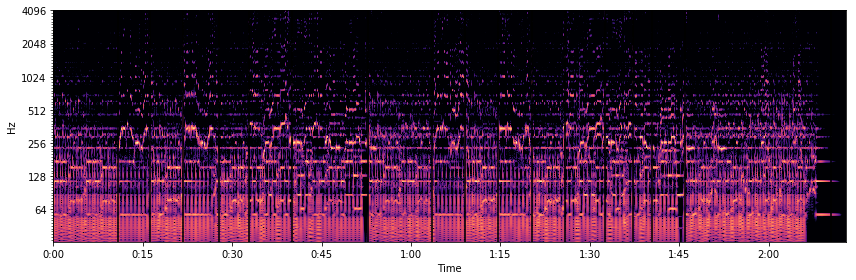

In [31]:
plt.figure(figsize=(12, 4))
librosa.display.specshow(C, y_axis='cqt_hz', sr=sr, bins_per_octave=12*3, x_axis='time')
plt.vlines(bound_times, 0, 4106, color='black', linewidth=2, alpha=0.8)
plt.tight_layout()